Final Project Notebook

In [1]:
# SETUP CODE
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

<h2>Introduction</h2>

Bank managers have been asking the same question for a long time. What sort of clients will subscribe to a term deposit? To solve this question, we have downloaded the “bank-additional-full.csv” spreadsheet from the Portuguese banking institution to analyze the results and conduct the research. By using the KNN classification method, we aim to predict if the client will subscribe to a term deposit or not. 

"Bank-additional-full.csv” is a document representing the marketing efforts of the Portuguese banking institution. 21 variables are measured, with the classification variable being whether or not a client will subscribe to a term deposit. A term deposit is a fixed-term investment that contains the deposit of funds into an account at a financial institution and receives a certain amount of interest on the maturity date. This data was originally produced by researchers at the University Institute of Lisbon for a report highlighting a data-driven approach to predict the successfulness of bank telemarketing.

This dataset features 20 attributes regarding demographics (age, job, marital status), economic and educational situation (level of education, possession of a housing loan), and historical information’s relationship to the banking institution (last month of contact, outcome from previous marketing campaign). In order to make this prediction more effective and accurate, we have selected the 7 most important predictors to conduct KNN classification analysis, and each of the target variables contains 41188 observations, which makes the whole prediction more trustworthy and accurate. We will separate 75% of the data into the training set and 25% of the remaining into the testing set in order to find out the most suitable k-neighbour in our function. After identifying the correct "k" for the function, we will use "ggpairs" to create a visual comparison to demonstrate the correlation between each variable measured, and at last, come up with an accurate and effective prediction. 

Our project will be able to answer the question; given a new client (a new row in the table), will the client subscribe to a term deposit or not?  (335 Words)

<h2> Methods & Results </h2>

To predict will the client subscribe to a term deposit or not, 

In [2]:
# Retrieving and preparing the dataset for classification

# Set the seed
set.seed(7134) 

# Read the dataset and discard the unnecessary columns
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip",temp)
bank_data <- read.table(unz(temp, "bank-additional/bank-additional-full.csv"), sep=";", header=TRUE) %>%
    select(age, job, marital, education, housing, loan, campaign, y)
unlink(temp)
bank_data <- as_tibble(bank_data)
bank_data
nrow(bank_data)

age,job,marital,education,housing,loan,campaign,y
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
56,housemaid,married,basic.4y,no,no,1,no
57,services,married,high.school,no,no,1,no
37,services,married,high.school,yes,no,1,no
40,admin.,married,basic.6y,no,no,1,no
56,services,married,high.school,no,yes,1,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
73,retired,married,professional.course,yes,no,1,yes
46,blue-collar,married,professional.course,no,no,1,no
56,retired,married,university.degree,yes,no,2,no


[1] 41188

In [3]:
# Set the seed
set.seed(7134) 

# Filter out rows with unknown data
bank_data_filtered <- bank_data %>%
    filter(job != "unknown",
           marital != "unknown",
           education != "unknown",
           housing != "unknown",
           loan != "unknown")
             
# Convert all string columns to integers (needed for classification)
bank_data_nums <- bank_data_filtered %>%
    mutate(
        age = as.double(age),
        job = as.double(unclass(factor(job))), 
        marital = as.double(unclass(factor(marital))), 
        education = as.double(unclass(factor(education))), 
        housing = as.double(unclass(factor(housing))),
        loan = as.double(unclass(factor(loan))),
        y = factor(y)
    )
bank_data_nums

age,job,marital,education,housing,loan,campaign,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
56,4,2,1,1,1,1,no
57,8,2,4,1,1,1,no
37,8,2,4,2,1,1,no
40,1,2,2,1,1,1,no
56,8,2,4,1,2,1,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
73,6,2,6,2,1,1,yes
46,2,2,6,1,1,1,no
56,6,2,7,2,1,2,no


In [4]:
# Set the seed
set.seed(7134) 

# Split the dataset into training and testing sets
bank_split <- initial_split(bank_data_nums, prop = 0.75, strata = y)  
bank_train <- training(bank_split)   
bank_test <- testing(bank_split)
bank_test
bank_train

age,job,marital,education,housing,loan,campaign,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
40,1,2,2,1,1,1,no
56,8,2,4,1,2,1,no
57,4,1,1,2,1,1,no
55,6,3,4,2,1,1,no
39,7,2,3,1,1,1,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
32,1,2,7,1,1,1,yes
38,3,2,7,1,1,2,no
62,6,2,7,2,1,1,yes


age,job,marital,education,housing,loan,campaign,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
56,4,2,1,1,1,1,no
57,8,2,4,1,1,1,no
37,8,2,4,2,1,1,no
45,8,2,3,1,1,1,no
59,1,2,6,1,1,1,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,11,3,1,2,1,1,no
46,2,2,6,1,1,1,no
56,6,2,7,2,1,2,no


In [5]:
# Perform cross validation to determine the ideal # of neighbours

# Set the seed
set.seed(7134) 

# No need to use the entire dataset for this, 
# especially since cross validation would take too long on a datset so large
bank_sample <- rep_sample_n(bank_train, 1000)

bank_k_recipe <- recipe(y ~ age+job+education+housing+loan+marital+campaign, data = bank_sample) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

bank_vfold <- vfold_cv(bank_sample, v = 5, strata = y)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [6]:
# Set the seed
set.seed(7134) 
bank_knn_results <- workflow() %>%
       add_recipe(bank_k_recipe) %>%
       add_model(knn_spec) %>%
       tune_grid(resamples = bank_vfold, grid = 20) %>%
       collect_metrics()
bank_knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7970081,5,0.003626619,Model01
2,roc_auc,binary,0.5471054,5,0.013378169,Model01
3,accuracy,binary,0.8639887,5,0.004081490,Model02
3,roc_auc,binary,0.5535053,5,0.018423863,Model02
4,accuracy,binary,0.8629937,5,0.003443976,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.5690356,5,0.026289492,Model12
14,accuracy,binary,0.8840038,5,0.000859023,Model13
14,roc_auc,binary,0.5702325,5,0.025134607,Model13


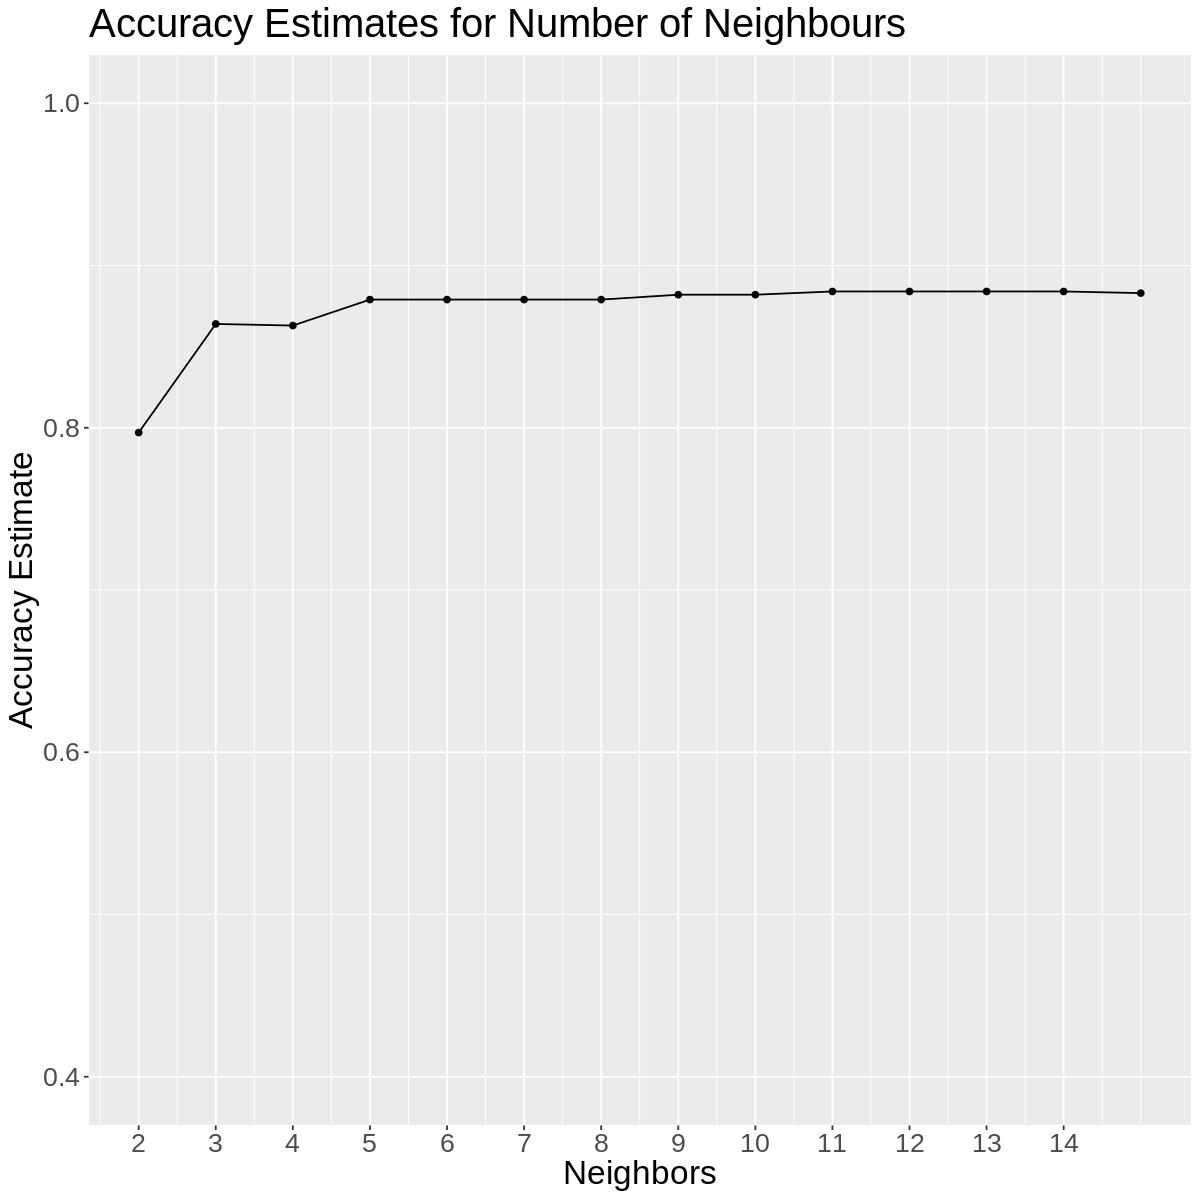

In [7]:
# Plot the accuracies of each k determined by cross validation
# to find the ideal value of k
options(repr.plot.width=10, repr.plot.height=10)

accuracies <- bank_knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy Estimates for Number of Neighbours") +
       theme(text = element_text(size = 20)) +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [8]:
# Comments from the TA
# How can we make sure the data does not include any missing values? Make sure to include a code checking for missing data. 

From the above plot, we can see that although having 9-14 neighbours would technically be the most accurate, the accuracy of any k greater than 2 is practically the same, therefore we will choose k = 3, since any k lower would be noticeably less accurate, and any k greater would be just as accurate, but require more computation time.

In [9]:
bank_recipe <- recipe(y ~ age+job+education+housing+loan+marital+campaign, data = bank_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
bank_recipe

bank_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
       set_engine("kknn") %>%
       set_mode("classification")

bank_spec

bank_fit <- workflow() %>%
        add_recipe(bank_recipe) %>%
        add_model(bank_spec) %>%
        fit(data = bank_train)
bank_fit

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          7

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 3
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1183197
Best kernel: rectangular
Best k: 3

In [10]:
bank_predictions <- predict(bank_fit , bank_test) %>%
       bind_cols(bank_test)
bank_predictions

bank_metrics <- bank_predictions %>%
         metrics(truth = y, estimate = .pred_class)
bank_metrics

bank_conf_mat <- bank_predictions %>% 
       conf_mat(truth = y, estimate = .pred_class)
bank_conf_mat

.pred_class,age,job,marital,education,housing,loan,campaign,y
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
no,40,1,2,2,1,1,1,no
no,56,8,2,4,1,2,1,no
no,57,4,1,1,2,1,1,no
no,55,6,3,4,2,1,1,no
no,39,7,2,3,1,1,1,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
no,32,1,2,7,1,1,1,yes
no,38,3,2,7,1,1,2,no
yes,62,6,2,7,2,1,1,yes


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.87217573
kap,binary,0.06693358


          Truth
Prediction   no  yes
       no  8259  985
       yes  237   79

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



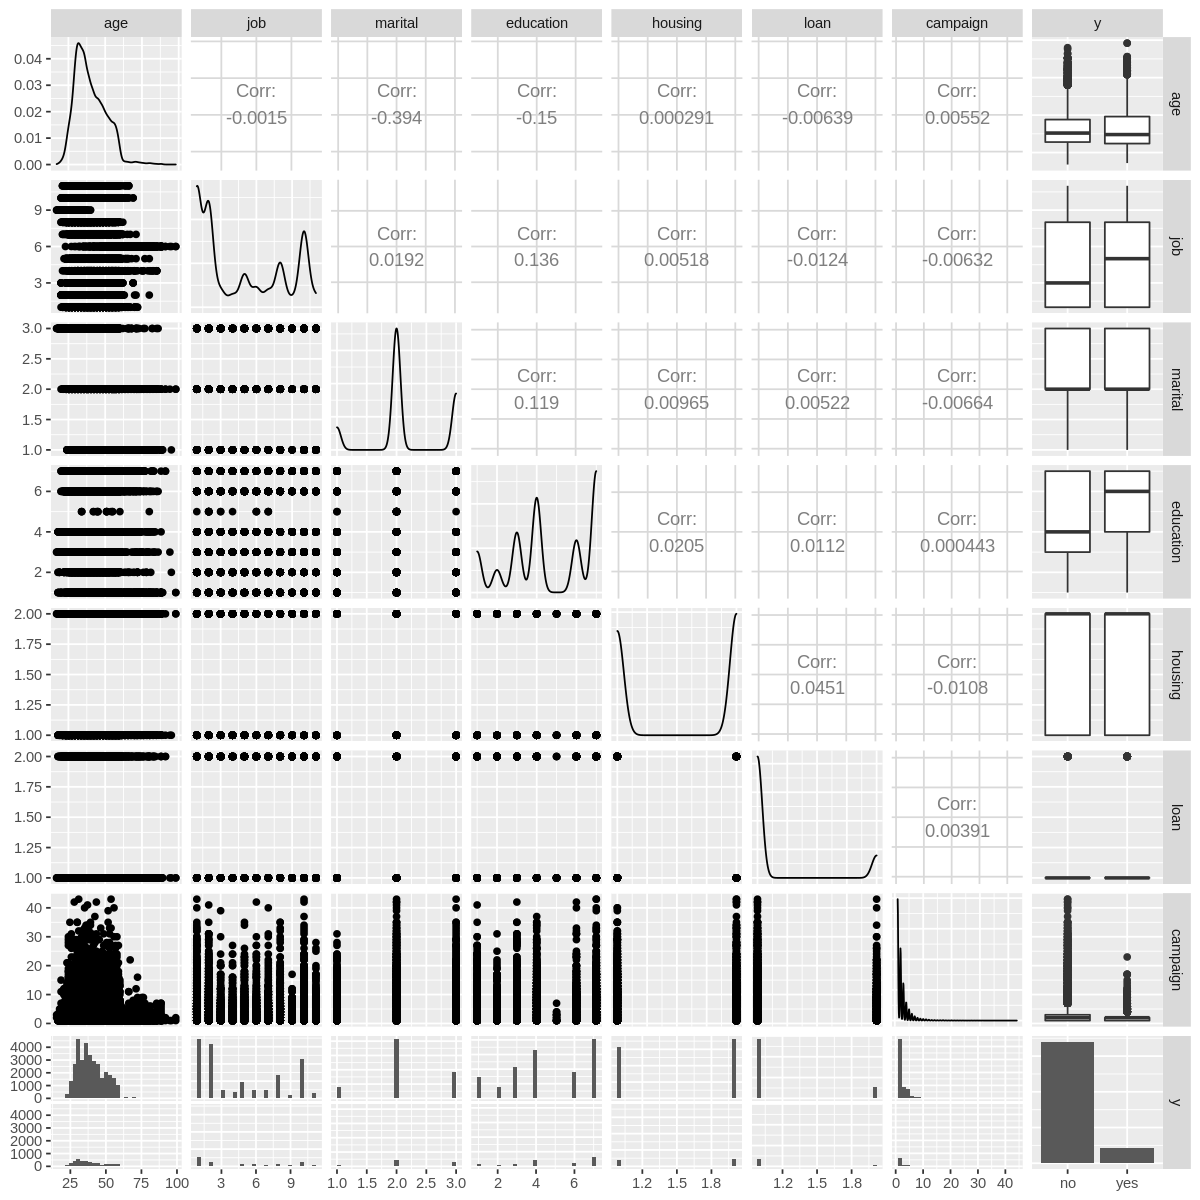

In [11]:
library(GGally)
plot_pairs <- bank_data_nums %>%
  select(age, job, marital, education, housing, loan, campaign, y,)%>%
  ggpairs
plot_pairs

<h2> Discussion </h2>
Summarize what you found
Discuss whether this is what you expected to find?
Discuss what impact could such findings have?
Discuss what future questions could this lead to?

<h2> References </h2>